In [1]:
import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
BATCH_SIZE = 64
MODEL_NAME = 'vit_small_patch16_224'
LEARNING_RATE = 5e-4
NUM_EPOCHS = 12
WEIGHT_DECAY = 0.01  # L2 regularization
PATIENCE = 4  # early stopping patience
WARMUP_EPOCHS = max(1, int(0.05 * NUM_EPOCHS))

# --- Data Transforms (mild augmentation) ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.1)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Data Loading (use all data) ---
train_dir = 'vit_data/train'
val_dir = 'vit_data/val'

image_datasets = {x: datasets.ImageFolder(os.path.join('vit_data', x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")

Dataset sizes: {'train': 27564, 'val': 5900}
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Number of classes: 17


In [2]:
# --- Model Setup with Dropout ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create ViT model with dropout
model = timm.create_model(MODEL_NAME, pretrained=True, drop_rate=0.2)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace head with dropout layer
num_classes = len(class_names)
num_ftrs = model.head.in_features
model.head = nn.Sequential(
    nn.Dropout(0.2),  # Head dropout for regularization
    nn.Linear(num_ftrs, num_classes)
)
model = model.to(device)

# Optimizer with weight decay (L2 regularization) & Loss with label smoothing
optimizer = optim.AdamW(model.head.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Cosine scheduler (after warmup)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=max(1, NUM_EPOCHS - WARMUP_EPOCHS),
    eta_min=LEARNING_RATE * 0.1
)

print(f"Model initialized with regularization. Training only the head.")

Using device: cpu


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Model initialized with regularization. Training only the head.


In [3]:
# --- Training Function with History Tracking ---
def set_lr(optimizer, lr_value):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_value


def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    
    # History for plotting
    history = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }

    for epoch in range(num_epochs):
        # Warmup then cosine
        if epoch < WARMUP_EPOCHS:
            warmup_lr = LEARNING_RATE * float(epoch + 1) / float(WARMUP_EPOCHS)
            set_lr(optimizer, warmup_lr)
        else:
            scheduler.step()

        print(f'Epoch {epoch}/{num_epochs - 1} | lr={optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Phase'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    probabilities = torch.softmax(outputs, dim=1)
                    predicted_classes = torch.argmax(probabilities, dim=1)
                    
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predicted_classes == labels.data)
                all_preds.extend(predicted_classes.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')
            
            # Store history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            history[f'{phase}_f1'].append(epoch_f1)

            if phase == 'val':
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_acc = epoch_acc
                    patience_counter = 0
                else:
                    patience_counter += 1

        print()

        if patience_counter >= PATIENCE:
            print(f'Early stopping triggered at epoch {epoch} (no val loss improvement for {PATIENCE} epochs).')
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

# --- Start Training ---
model_ft, history = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)

Epoch 0/11 | lr=0.000500
----------


train Phase:   0%|          | 0/431 [00:00<?, ?it/s]

train Loss: 1.1312 Acc: 0.8222 F1: 0.8223


val Phase:   0%|          | 0/93 [00:00<?, ?it/s]

val Loss: 0.7400 Acc: 0.9749 F1: 0.9748

Epoch 1/11 | lr=0.000491
----------


train Phase:   0%|          | 0/431 [00:00<?, ?it/s]

train Loss: 0.8007 Acc: 0.9551 F1: 0.9551


val Phase:   0%|          | 0/93 [00:00<?, ?it/s]

val Loss: 0.7036 Acc: 0.9812 F1: 0.9810

Epoch 2/11 | lr=0.000464
----------


train Phase:   0%|          | 0/431 [00:00<?, ?it/s]

train Loss: 0.7612 Acc: 0.9687 F1: 0.9687


val Phase:   0%|          | 0/93 [00:00<?, ?it/s]

val Loss: 0.6903 Acc: 0.9815 F1: 0.9814

Epoch 3/11 | lr=0.000422
----------


train Phase:   0%|          | 0/431 [00:00<?, ?it/s]

train Loss: 0.7492 Acc: 0.9702 F1: 0.9702


val Phase:   0%|          | 0/93 [00:00<?, ?it/s]

val Loss: 0.6867 Acc: 0.9844 F1: 0.9840

Epoch 4/11 | lr=0.000368
----------


train Phase:   0%|          | 0/431 [00:00<?, ?it/s]

train Loss: 0.7427 Acc: 0.9718 F1: 0.9719


val Phase:   0%|          | 0/93 [00:00<?, ?it/s]

val Loss: 0.6887 Acc: 0.9820 F1: 0.9816

Epoch 5/11 | lr=0.000307
----------


train Phase:   0%|          | 0/431 [00:00<?, ?it/s]

train Loss: 0.7377 Acc: 0.9728 F1: 0.9728


val Phase:   0%|          | 0/93 [00:00<?, ?it/s]

val Loss: 0.6788 Acc: 0.9841 F1: 0.9839

Epoch 6/11 | lr=0.000243
----------


train Phase:   0%|          | 0/431 [00:00<?, ?it/s]

train Loss: 0.7359 Acc: 0.9741 F1: 0.9741


val Phase:   0%|          | 0/93 [00:00<?, ?it/s]

val Loss: 0.6808 Acc: 0.9839 F1: 0.9837

Epoch 7/11 | lr=0.000182
----------


train Phase:   0%|          | 0/431 [00:00<?, ?it/s]

train Loss: 0.7362 Acc: 0.9741 F1: 0.9740


val Phase:   0%|          | 0/93 [00:00<?, ?it/s]

val Loss: 0.6778 Acc: 0.9846 F1: 0.9844

Epoch 8/11 | lr=0.000128
----------


train Phase:   0%|          | 0/431 [00:00<?, ?it/s]

train Loss: 0.7334 Acc: 0.9755 F1: 0.9755


val Phase:   0%|          | 0/93 [00:00<?, ?it/s]

val Loss: 0.6789 Acc: 0.9851 F1: 0.9848

Epoch 9/11 | lr=0.000086
----------


train Phase:   0%|          | 0/431 [00:00<?, ?it/s]

train Loss: 0.7329 Acc: 0.9750 F1: 0.9749


val Phase:   0%|          | 0/93 [00:00<?, ?it/s]

val Loss: 0.6764 Acc: 0.9863 F1: 0.9860

Epoch 10/11 | lr=0.000059
----------


train Phase:   0%|          | 0/431 [00:00<?, ?it/s]

train Loss: 0.7311 Acc: 0.9746 F1: 0.9746


val Phase:   0%|          | 0/93 [00:00<?, ?it/s]

val Loss: 0.6757 Acc: 0.9866 F1: 0.9863

Epoch 11/11 | lr=0.000050
----------


train Phase:   0%|          | 0/431 [00:00<?, ?it/s]

train Loss: 0.7292 Acc: 0.9769 F1: 0.9768


val Phase:   0%|          | 0/93 [00:00<?, ?it/s]

val Loss: 0.6772 Acc: 0.9869 F1: 0.9866

Training complete in 627m 12s
Best val Acc: 0.986610


In [4]:
# --- Save the Model ---
model_save_path = "vit_small_model.pth"
torch.save(model_ft.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to vit_small_model.pth


In [5]:
# --- Test the Model ---
test_dir = 'vit_data/test'
test_dataset = datasets.ImageFolder(test_dir, data_transforms['val'])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Evaluate the model on the test set
model_ft.eval()
test_corrects = 0
test_total = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing Phase'):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)

        test_corrects += torch.sum(predicted_classes == labels.data).item()
        test_total += labels.size(0)
        all_test_preds.extend(predicted_classes.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

test_acc = test_corrects / test_total
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test F1 (macro): {test_f1:.4f}')

Testing Phase:   0%|          | 0/93 [00:00<?, ?it/s]

Test Accuracy: 0.9867
Test F1 (macro): 0.9864


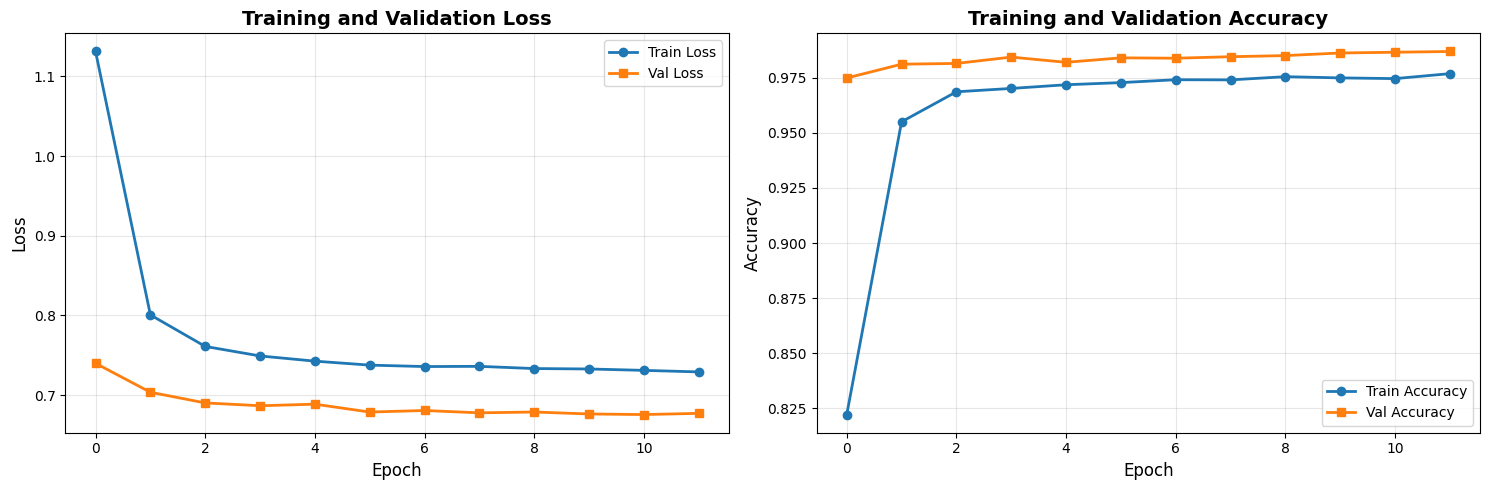


FINAL TRAINING METRICS
Final Train Loss: 0.7292
Final Train Acc: 0.9769
Final Train F1 (macro): 0.9768
Final Val Loss: 0.6772
Final Val Acc: 0.9869
Final Val F1 (macro): 0.9866


In [6]:
# --- Plot Training History ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot Accuracy
ax2.plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
ax2.plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n" + "="*50)
print("FINAL TRAINING METRICS")
print("="*50)
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Train Acc: {history['train_acc'][-1]:.4f}")
print(f"Final Train F1 (macro): {history['train_f1'][-1]:.4f}")
print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")
print(f"Final Val Acc: {history['val_acc'][-1]:.4f}")
print(f"Final Val F1 (macro): {history['val_f1'][-1]:.4f}")
print("="*50)